## Task 1. 
### Metaheurística constructiva para el problema de recogida de basuras

Oscar Mauricio Cepeda Valero  
201123181  
Metaheurísticas

In [2]:
import numpy as np
import pandas as pd
#from gurobipy import *
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from glob import glob
import time

### Procedure to read archives

In [3]:
## procedure to read the instance, input is the direction, return dataframe and capacity and demand
def readins(DirAR):
    ### get and convert data in dataframe OK
    df = pd.read_csv(DirAR, sep=";", names = ['uno'])#, index_col=0)
    df = df.drop(df.index[0:10])
    df = df.drop(df.index[len(df)-1])  ### review data size
    df[['arc','other']]=df.uno.str.split(')',expand=True) # get arcs
    df[['cost1','demand']]=df.other.str.split('demanda ',expand=True) # get demand
    df[['res','cost']]=df.cost1.str.split('coste ',expand=True) # get demand
    df[['ini','fin']]=df.arc.str.split(', ',expand=True) # get demand
    df['ini'] = df['ini'].apply(lambda x: str(x).replace("(",""))
    df.reset_index(inplace = True)
    df.drop(['uno','other','cost1','res','arc','index'], axis = 1, inplace = True)
    #df.head()
    
    ## get the capacity and quantity of vehicles
    df1 = pd.read_csv(DirAR, sep=";", names = ['uno'])#, index_col=0)
    df1[['name','value']]=df1.iloc[5:7].uno.str.split(':',expand=True) # get arcs
    N = int(df1.iloc[5,2])
    #print('Vehicles: ', Nveh)
    C = int(df1.iloc[6,2])
    #print('Capacity: ', Capacity)
    return(df, N, C)

#### Procedure to create network

In [4]:
def creatg(dataf):
    net = nx.Graph()
    for index, i in dataf.iterrows():
        net.add_edge(int(i[2]),int(i[3]), length=int(i[1]))
    plt.show(nx.draw_networkx(net,node_color = "blue", edge_color = 'blue'))
    return(net)

## First algorithm

In [5]:
#DirAR1 = "C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb/gdb7.dat"

In [6]:
## procedure read archive and return dataframe with arcs, and quantity of vehicles and capacity
#df, Nveh, Capacity = readins(DirAR1)

In [7]:
## procedure to create network
#net1 = creatg(df)

In [8]:
## procedures to convert dictionary to dataframe
def ShowOK (data):
    QM = pd.DataFrame(data, index=range(1))
    QM = QM.stack(level=0)
    QM = QM.reset_index(level=0, drop = True)
    return(QM)

### Functions
##### functions to create parameters

In [9]:
## DATA
## demand dictionary
## dictionary with arcs, include the same arc with inverse direction
def createDem(df1):
    DicDem = {(int(i[2]),int(i[3])): int(i[0])  for index, i in df1.iterrows()}
    DicD2 = {(int(i[3]),int(i[2])): int(i[0])  for index, i in df1.iterrows()} ##inverse arc
    DicDem.update(DicD2)
    #DicDem
    return (DicDem)

In [10]:
## cost dictionary
## dictionary has a cost of arcs in both directions
def creatcos(df1):
    Diccos = {(int(i[2]),int(i[3])): int(i[1])  for index, i in df1.iterrows()}
    Dicc2 = {(int(i[3]),int(i[2])): int(i[1])  for index, i in df1.iterrows()} ## inverse cost
    Diccos.update(Dicc2)
    #Diccos
    return (Diccos)

In [11]:
## arc list
## create list with arcs and inverse of arcs
def creatarclis(df1):
    Lis1 = [(int(i[2]),int(i[3]))  for index, i in df1.iterrows()]
    Lis2 = [(int(i[3]),int(i[2]))  for index, i in df1.iterrows()] ## inverse arc
    Lis1 = Lis1 + Lis2
    #Lis1
    return (Lis1)

In [12]:
## get minimal distance between each node
#nx.shortest_path(net1,source=1,target=5, weight = 'length')

In [13]:
## sortest distances matrix
#Sdis = {(i,j): nx.shortest_path_length(net1,source=i,target=j, weight = 'length') for i in net1.nodes() for j in net1.nodes()}
#Sdis

#### Function to get objective function

In [14]:
## objective function -- function get list of arcs, cost and matrix, return cost of arc list
def CosR(LisOK, DiccOK, Mx):
    FOc = 0
    for index, i in enumerate(LisOK):
        if (index < len(LisOK)-1):
            FOc = FOc + DiccOK[i] ## sum edge cost
            ori = i[1] ## get the origin position
            des = LisOK[index+1][0] ##get destination
            #print(i , Diccos[i])
            #print(ori,' ,',des, ' , ' , Sdis[ori,des])
            FOc = FOc + Mx[ori,des] ## cost to the next destination
            #print(Lis1[index+1][0])
    FOc = FOc + DiccOK[LisOK[len(LisOK)-1]]## the last edge
    FOc = FOc + Mx[LisOK[len(LisOK)-1][1],1] ## return to deposit
    return (FOc)

In [19]:
# call function FO
#CosR(Lis1, Diccos, Sdis)

Procedure neighbor search

In [20]:
### matrix cost between each arc couple
#MxDsEdge = {(i,j): Sdis[i[1],j[0]] for i in Lis1 for j in Lis1}
#MxDsEdge

In [21]:
### function receive a list and capacity and return route by neighbor
## inputs (list, demand, capacity)
def route(LPP, deman, Q, MxDsEdge1):
    
    LOrd = [] ## list with all arcs 
    nex1 = LPP[0]
    
    while (len(LPP)>2 and Q>1): 
        LOrd.append(nex1) ## add to list of order arcs to visit
        Q = Q - deman[nex1] ## add demand 
        inex1 = (nex1[1],nex1[0]) ## find inverse arc
        LPP.remove(nex1) ## remove form the candidates
        LPP.remove(inex1)  ## remove inverse arc, because it has been already visited
        #print(nex1)
        TempD = {i: MxDsEdge1[(nex1, i)] for i in LPP} ## find the dictionary with candidates
        nex1 = min(TempD, key = lambda k: TempD[k])  ## get the closest of the candidates
    LOrd.append(nex1)
    Q = Q - deman[nex1] ## add demand
    inex1 = (nex1[1],nex1[0]) # find inverse arc
    LPP.remove(nex1) ## remove form the candidates
    LPP.remove(inex1) ## remove arc inverse
    
    return (LOrd, LPP) ## return route and arcs without route

Procedure to get route set

In [22]:
## procedure
## Inputs
## Lis = Arcs without route
## Dictionary of demands
## Capacity = vehicel capacity
## Diccos = dictionary with arc cost
## Sdis = Matrix with shorter distances between nodes


def gene_proced (Lis, DicDem1, Capacity1, Diccos1, Sdis1, Matx):
    Ans = [] # list with arcs sequence and demand of route
    Ltest = Lis.copy() ## creation of a copy of arcs list
    #print(Ltest)
    while Ltest:
        #route(Ltest, DicDem, Capacity)
        Sol = route(Ltest, DicDem1, Capacity1, Matx)
        rout = Sol[0]
        FOR = CosR(rout, Diccos1, Sdis1)
        #print(rout)
        #print(FOR)
        Ans.append([rout,FOR])
        Ltest = Sol[1]
    return(Ans)

In [23]:
#gene_proced(Lis1, DicDem, Capacity, Diccos, Sdis)

In [26]:
## get total objective function
#SolT = {index: i[1] for index, i in enumerate(Ans)}
#sum(SolT.values())

#### Procedure for all files

In [ ]:
## read folder with all instances
file = "C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb"
a_files = glob(file + '/*.dat')
#len(a_files)

23

In [ ]:
df, Nveh, Capacity = readins(i)

Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb1.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb1.dat
5


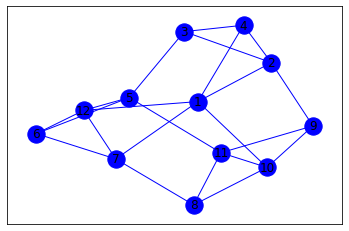

nodes:  12 , edges:  22
[[[(1, 2), (2, 3), (3, 4), (4, 1), (1, 7)], 98], [[(1, 10), (10, 11), (11, 5), (5, 6), (6, 7)], 73], [[(1, 12), (12, 5), (5, 3), (6, 12), (12, 7)], 64], [[(2, 4), (2, 9), (9, 10), (10, 8), (8, 11)], 78], [[(7, 8), (11, 9)], 47]]
360
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb10.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb10.dat
10


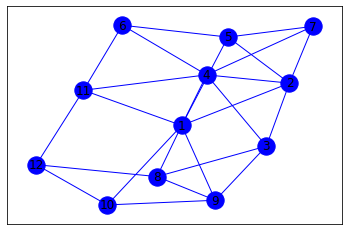

nodes:  12 , edges:  25
[[[(1, 8), (8, 9), (9, 10), (10, 12), (12, 8), (8, 3), (3, 4)], 82], [[(1, 9), (9, 3), (3, 2), (2, 1), (1, 10), (12, 11), (11, 1), (1, 4)], 84], [[(2, 4), (4, 6), (6, 11), (11, 4), (4, 7), (7, 2)], 76], [[(2, 5), (5, 1), (5, 6), (5, 7)], 75]]
317
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb11.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb11.dat
50


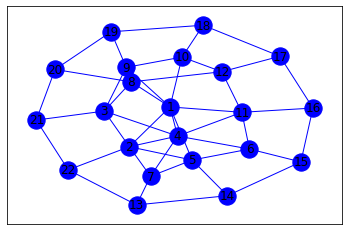

nodes:  22 , edges:  45
[[[(1, 8), (8, 9), (9, 10), (10, 12), (12, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22)], 107], [[(1, 9), (9, 19), (9, 3), (3, 4), (4, 1), (1, 10), (10, 18), (17, 16), (16, 11), (11, 12), (12, 8)], 76], [[(1, 11), (11, 4), (4, 6), (6, 11), (16, 15), (15, 6), (6, 5), (5, 1), (1, 2), (2, 3), (3, 8), (8, 20)], 130], [[(2, 4), (4, 7), (7, 2), (2, 5), (5, 14), (14, 15), (14, 13), (13, 22), (22, 2), (7, 5)], 108], [[(3, 21), (7, 13)], 41]]
462
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb12.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb12.dat
35


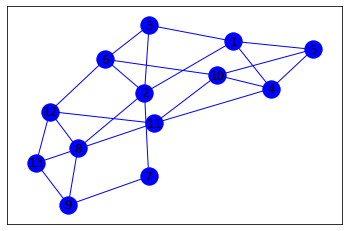

nodes:  13 , edges:  23
[[[(1, 2), (2, 3), (3, 6), (6, 10), (10, 11)], 97], [[(1, 3), (1, 4), (4, 5), (5, 10)], 60], [[(1, 5), (10, 4), (4, 11), (11, 12), (12, 13)], 155], [[(2, 6), (6, 12), (12, 8), (8, 9), (9, 13), (13, 11), (9, 7), (7, 2), (2, 8)], 176]]
488
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb13.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb13.dat
41


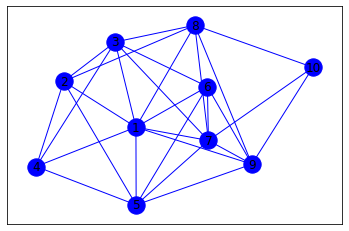

nodes:  10 , edges:  28
[[[(1, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)], 103], [[(1, 6), (6, 9), (9, 1), (1, 7), (7, 9), (9, 5), (5, 7)], 164], [[(1, 8), (8, 10), (10, 7), (7, 3), (3, 1), (1, 2)], 170], [[(2, 3), (3, 6), (3, 8), (8, 2), (2, 5), (5, 4)], 64], [[(4, 1), (4, 2), (4, 3)], 54]]
555
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb14.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb14.dat
21


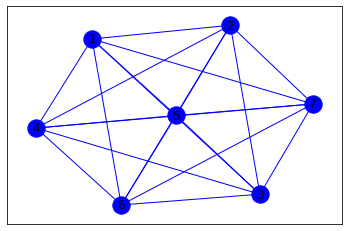

nodes:  7 , edges:  21
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 1)], 33], [[(1, 3), (3, 5), (5, 7), (7, 2), (2, 4), (4, 6)], 28], [[(1, 4), (4, 7), (7, 3), (3, 6), (6, 1), (1, 5)], 34], [[(2, 5), (2, 6)], 14]]
109
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb15.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb15.dat
37


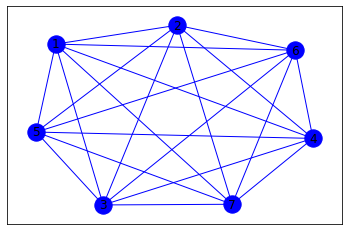

nodes:  7 , edges:  21
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 1), (1, 3), (3, 5)], 27], [[(1, 4), (4, 6), (6, 1), (1, 5), (5, 7), (7, 2), (2, 4), (4, 7)], 21], [[(2, 5), (2, 6), (6, 3), (3, 7)], 13]]
61
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb16.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb16.dat
24


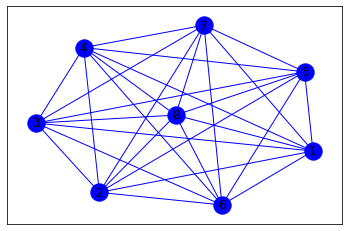

nodes:  8 , edges:  28
[[[(1, 2), (2, 3), (3, 4), (4, 5)], 24], [[(1, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 1)], 26], [[(1, 4), (4, 6), (6, 8), (8, 2), (2, 4), (4, 7), (7, 1), (1, 5), (5, 7)], 34], [[(1, 6), (6, 2), (2, 5), (5, 8), (8, 3), (3, 6), (2, 7)], 36], [[(3, 7), (8, 4)], 14]]
134
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb17.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb17.dat
41


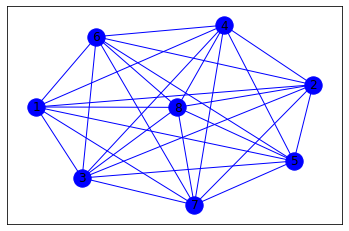

nodes:  8 , edges:  28
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 1), (1, 3)], 31], [[(1, 4), (4, 6), (6, 8), (8, 2), (2, 4), (4, 7), (7, 1), (1, 5)], 22], [[(1, 6), (6, 2), (2, 5), (5, 7), (7, 2), (3, 5), (5, 8), (8, 3)], 26], [[(3, 6), (3, 7), (4, 8)], 15]]
94
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb18.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb18.dat
37


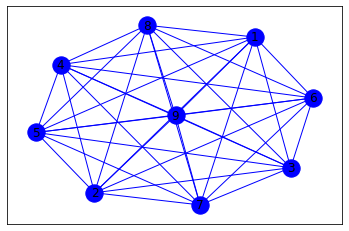

nodes:  9 , edges:  36
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 1), (1, 3)], 52], [[(1, 4), (4, 6), (6, 8), (8, 1), (1, 5), (5, 7), (7, 9), (9, 2), (2, 4), (4, 7), (7, 1), (1, 6), (6, 9), (9, 3)], 50], [[(2, 5), (5, 8), (8, 2), (2, 6), (6, 3), (3, 5), (5, 9), (9, 4)], 51], [[(2, 7), (7, 3), (3, 8), (8, 4)], 23]]
176
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb19.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb19.dat
27


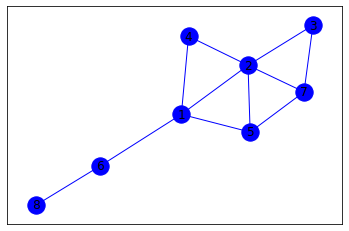

nodes:  8 , edges:  11
[[[(1, 2), (2, 3), (3, 7), (7, 2), (2, 4)], 25], [[(1, 4), (1, 5), (5, 7), (2, 5), (1, 6), (6, 8)], 36]]
61
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb2.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb2.dat
5


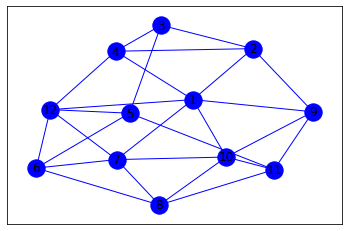

nodes:  12 , edges:  26
[[[(1, 2), (2, 3), (3, 4), (4, 12), (12, 1)], 60], [[(1, 4), (4, 2), (2, 9), (9, 10), (10, 11)], 81], [[(1, 7), (7, 8), (8, 10), (10, 1), (1, 9)], 71], [[(3, 5), (5, 6), (6, 7), (7, 10), (8, 11)], 63], [[(5, 11), (11, 9), (12, 5), (6, 8), (7, 12)], 111], [[(6, 12)], 7]]
393
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb20.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb20.dat
27


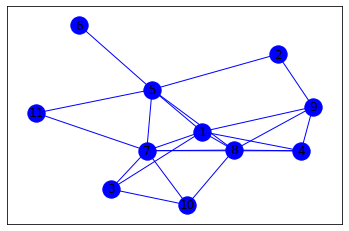

nodes:  11 , edges:  22
[[[(1, 3), (3, 7), (7, 8), (8, 9), (9, 1), (1, 4), (4, 7), (7, 10), (10, 3)], 40], [[(1, 5), (5, 6), (5, 7), (7, 11), (11, 5), (5, 8)], 43], [[(1, 7), (1, 8), (8, 10), (8, 4), (4, 9), (9, 2)], 35], [[(2, 5)], 9]]
127
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb21.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb21.dat
27


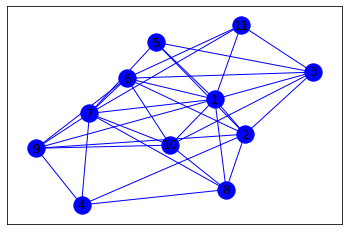

nodes:  11 , edges:  33
[[[(1, 2), (2, 3), (3, 5), (5, 7), (7, 8)], 17], [[(1, 3), (3, 6), (6, 7), (7, 9), (9, 10), (10, 1), (1, 5), (5, 2)], 52], [[(1, 6), (6, 9), (9, 1), (1, 7), (7, 10), (10, 3), (3, 11), (11, 1)], 30], [[(1, 8), (8, 10), (10, 6), (6, 11), (11, 7), (7, 4), (4, 8), (8, 2)], 34], [[(2, 4), (4, 9), (9, 2), (2, 6)], 24]]
157
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb22.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb22.dat
27


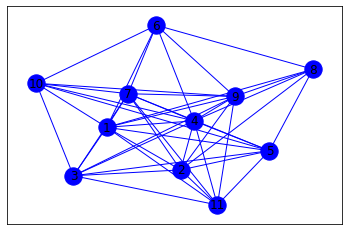

nodes:  11 , edges:  44
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 7), (7, 9), (9, 10)], 45], [[(1, 3), (3, 5), (5, 8), (8, 9), (9, 11), (11, 1), (1, 4), (4, 6), (6, 7)], 35], [[(1, 5), (5, 10), (10, 1), (1, 6), (6, 8), (8, 1)], 20], [[(1, 7), (7, 10), (10, 3), (3, 7), (7, 11), (11, 2), (2, 4), (4, 7)], 20], [[(1, 9), (9, 2), (2, 5), (5, 11), (11, 3), (3, 9)], 45], [[(2, 7), (2, 8), (8, 4), (4, 9), (9, 6), (6, 10), (10, 4), (4, 11)], 35]]
200
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb23.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb23.dat
27


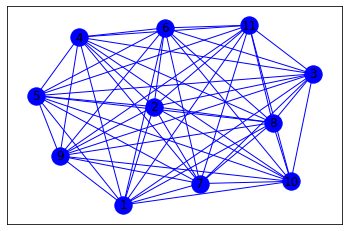

nodes:  11 , edges:  55
[[[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)], 31], [[(1, 3), (3, 5), (5, 7), (7, 9), (9, 10), (10, 11), (11, 1), (1, 4)], 25], [[(1, 5), (5, 8), (8, 9), (9, 11), (11, 2)], 21], [[(1, 6), (6, 8), (8, 10), (10, 1), (1, 7)], 17], [[(1, 8), (8, 11), (11, 3), (3, 6), (6, 9), (9, 1), (2, 4), (4, 6), (6, 10), (10, 2), (2, 5)], 48], [[(2, 6), (6, 11), (11, 4), (4, 7), (7, 10), (10, 3), (3, 7)], 25], [[(2, 7), (7, 11), (11, 5), (5, 9), (9, 2), (2, 8), (8, 3)], 45], [[(3, 9), (9, 4), (4, 8), (4, 10), (10, 5)], 30]]
242
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb3.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb3.dat
5


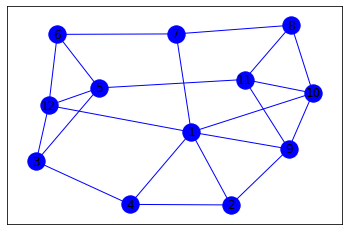

nodes:  12 , edges:  22
[[[(1, 2), (2, 4), (4, 1), (1, 7), (7, 8)], 85], [[(1, 9), (9, 10), (10, 11), (11, 5), (5, 6)], 73], [[(1, 10), (10, 8), (8, 11), (11, 9), (9, 2)], 61], [[(1, 12), (12, 3), (3, 4), (3, 5), (5, 12)], 70], [[(6, 7), (6, 12)], 15]]
304
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb4.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb4.dat
5


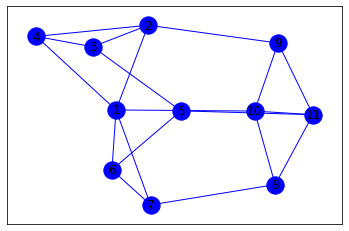

nodes:  11 , edges:  19
[[[(1, 2), (2, 3), (3, 4), (4, 1), (1, 6)], 76], [[(1, 7), (7, 6), (6, 5), (5, 11), (11, 8)], 100], [[(1, 10), (10, 11), (11, 9), (9, 10), (10, 8)], 86], [[(2, 4), (2, 9), (8, 7), (5, 3)], 101]]
363
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb5.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb5.dat
5


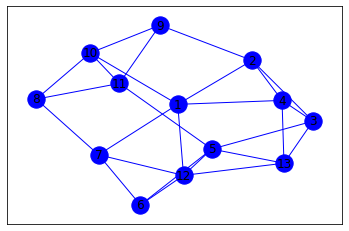

nodes:  13 , edges:  26
[[[(1, 2), (2, 3), (3, 4), (4, 13), (13, 3)], 98], [[(1, 4), (4, 2), (2, 9), (9, 10), (10, 11)], 85], [[(1, 7), (7, 8), (8, 10), (10, 1), (1, 12)], 57], [[(3, 5), (5, 6), (6, 7), (7, 12), (12, 13)], 76], [[(5, 11), (11, 8), (11, 9), (13, 5), (5, 12)], 103], [[(6, 12)], 7]]
426
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb6.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb6.dat
5


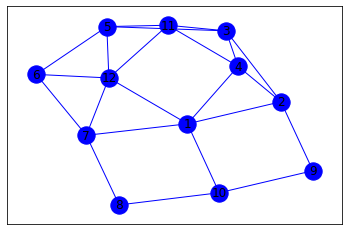

nodes:  12 , edges:  22
[[[(1, 2), (2, 3), (3, 4), (4, 11), (11, 3)], 98], [[(1, 4), (4, 2), (2, 9), (9, 10), (10, 1)], 63], [[(1, 7), (7, 8), (8, 10), (7, 12), (12, 11)], 101], [[(1, 12), (12, 5), (5, 6), (6, 7), (6, 12)], 37], [[(3, 5), (5, 11)], 45]]
344
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb7.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb7.dat
5


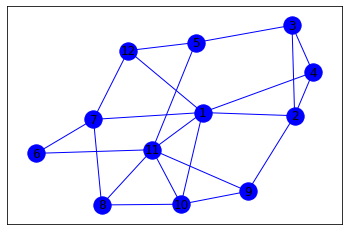

nodes:  12 , edges:  22
[[[(1, 2), (2, 3), (3, 4), (4, 1), (1, 7)], 106], [[(1, 10), (10, 11), (11, 1), (1, 12), (12, 5)], 78], [[(2, 4), (2, 9), (9, 10), (10, 8), (8, 11)], 66], [[(3, 5), (5, 11), (11, 6), (6, 7), (7, 8)], 62], [[(7, 12), (9, 11)], 68]]
380
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb8.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb8.dat
27


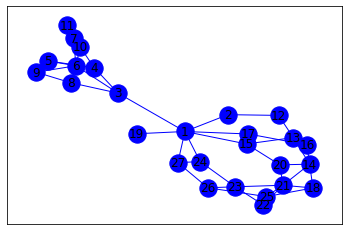

nodes:  27 , edges:  46
[[[(1, 3), (3, 4), (4, 5), (5, 6), (6, 7)], 35], [[(1, 15), (15, 17), (17, 1), (1, 19), (1, 24)], 30], [[(1, 27), (27, 24), (24, 23), (23, 26), (26, 27), (26, 25)], 44], [[(2, 1), (2, 12), (12, 13), (13, 14), (14, 16), (16, 17), (15, 20), (20, 21), (21, 22)], 65], [[(3, 6), (6, 8), (8, 9), (9, 5), (4, 6), (6, 9), (4, 10)], 53], [[(3, 8), (6, 10), (10, 11), (11, 7), (13, 15)], 59], [[(14, 18), (18, 21), (21, 23), (23, 22), (22, 25)], 29], [[(14, 20), (21, 25), (25, 18), (14, 21)], 40]]
355
Instance  C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb9.dat
C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb\gdb9.dat
27


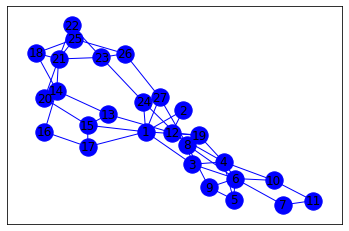

nodes:  27 , edges:  51
[[[(1, 3), (3, 4), (4, 5), (5, 6), (6, 7)], 31], [[(1, 15), (15, 17), (17, 1), (1, 19), (19, 4)], 24], [[(1, 24), (24, 27), (27, 1), (1, 2), (2, 12), (12, 13), (13, 14)], 41], [[(3, 6), (6, 8), (8, 9), (9, 5), (4, 6), (6, 9), (4, 10)], 45], [[(3, 8), (8, 24), (24, 23), (23, 26), (26, 27), (27, 8)], 28], [[(4, 12), (12, 19), (10, 11), (11, 7), (6, 10), (13, 15), (15, 20)], 57], [[(14, 16), (16, 17), (14, 18), (18, 21), (21, 22), (22, 23), (23, 21)], 64], [[(14, 20), (20, 21), (21, 25), (25, 26), (22, 25), (25, 18), (14, 21)], 50]]
340


In [ ]:
### complete procedure
#DirAR1 = "C:/Users/omcep/OneDrive/Documents/GitHub/Metaheuristics/gdb/gdb7.dat"
FOins= []

for index, i in enumerate(a_files):
    inicio = time.time()
    print('Instance ',i)

    # procedure to get dataframe with arcs, quantity of vehicles and capacity
    df, Nveh, Capacity = readins(i)
    print(i)
    print(Capacity)

    ## procedure to create network
    net1 = creatg(df)
    print('nodes: ', len(net1.nodes()), ', edges: ', len(net1.edges()))

    ## create demanda
    Dem = createDem(df)

    ## create cost
    Cost = creatcos(df)    

    ## creat arc list
    Lis1 = creatarclis(df)

    ## get matrix minimum distances
    Sdis = {(i,j): nx.shortest_path_length(net1,source=i,target=j, weight = 'length') for i in net1.nodes() for j in net1.nodes()}

    ### matrix cost between each arc couple
    MxDsEdge = {(i,j): Sdis[i[1],j[0]] for i in Lis1 for j in Lis1}

    ## procedure to get routes
    Answ = gene_proced(Lis1, Dem, Capacity, Cost, Sdis,MxDsEdge)
    print(Answ)

    ## get total objective function
    SolT = {index: i[1] for index, i in enumerate(Answ)}
    print(sum(SolT.values()))
    
    fin = time.time()

    FOins.append([i,sum(SolT.values()),fin-inicio])

In [ ]:
DFa = pd.DataFrame(FOins, columns = ['A', 'FO', 'Time'])
#DFa.iloc[1,0]
DFa[['A','Name']]=DFa.A.str.split('\\',expand=True) # get demand
DFa.drop(['A'], axis = 1, inplace = True)
DFa

,FO,Time,Name
0,360,0.379419,gdb1.dat
1,317,0.450218,gdb10.dat
2,462,0.674659,gdb11.dat
3,488,0.510393,gdb12.dat
4,555,0.492094,gdb13.dat
5,109,0.396128,gdb14.dat
6,61,0.326153,gdb15.dat
7,134,0.375791,gdb16.dat
8,94,1.127916,gdb17.dat
9,176,0.435916,gdb18.dat
